## <center><font color = red> Problem Defination: Predict whether a customer will subscribe to a term deposit or not

### Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from mlxtend.classifier import StackingCVClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from pylab import rcParams


%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')


### <font color = red > Load the Data

In [2]:
data_add_train = pd.read_csv("bank-additional-full.csv",header = 0, sep = ";")

data_add_test = pd.read_csv("bank-additional.csv",header = 0, sep = ";")


### <font color = red > Data Preprocessing 

In [4]:
# Check for Missing Values
data_add_train.isnull().sum() # In the documentation it was clearly mentioned that missing values are categorised  
                              # as Unknown. For our initial work let's continue without any change

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [5]:
## Replace 999 value in pdays and replace it with Zero
data_add_train.pdays[data_add_train.pdays == 999] = 0
data_add_test.pdays[data_add_test.pdays == 999] = 0


In [6]:
# Rename Column name
data_add_train.rename(columns={'y': 'Target'}, inplace=True)
data_add_test.rename(columns={'y': 'Target'}, inplace=True)


# Summary Statistics on entire data the data
data_add_train.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,0.221229,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,1.348874,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# Summary Statistics over Non-subscribed customers
data_add_train_0 = data_add_train.loc[data_add_train['Target'] == 'no']
data_add_train_0.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36548.0,39.911185,9.898132,17.000,32.000,38.000,47.000,95.000
duration,36548.0,220.844807,207.096293,0.000,95.000,163.500,279.000,4918.000
campaign,36548.0,2.633085,2.873438,1.000,1.000,2.000,3.000,56.000
pdays,36548.0,0.092864,0.896951,0.000,0.000,0.000,0.000,22.000
previous,36548.0,0.132374,0.409199,0.000,0.000,0.000,0.000,7.000
emp.var.rate,36548.0,0.248875,1.482932,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,36548.0,93.603757,0.558993,92.201,93.075,93.918,93.994,94.767
cons.conf.idx,36548.0,-40.593097,4.391155,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,36548.0,3.811491,1.638187,0.634,1.405,4.857,4.962,5.045
nr.employed,36548.0,5176.166600,64.571979,4963.600,5099.100,5195.800,5228.100,5228.100


In [9]:
# Summary Statistics over subscribed customers
data_add_train_1 = data_add_train.loc[data_add_train['Target'] == 'yes']
data_add_train_1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4640.0,40.913147,13.837476,17.000,31.000,37.000,50.000,98.000
duration,4640.0,553.191164,401.171871,37.000,253.000,449.000,741.250,4199.000
campaign,4640.0,2.051724,1.666245,1.000,1.000,2.000,2.000,23.000
pdays,4640.0,1.232328,2.943367,0.000,0.000,0.000,0.000,27.000
previous,4640.0,0.492672,0.860344,0.000,0.000,0.000,1.000,6.000
emp.var.rate,4640.0,-1.233448,1.623626,-3.400,-1.800,-1.800,-0.100,1.400
cons.price.idx,4640.0,93.354386,0.676644,92.201,92.893,93.200,93.918,94.767
cons.conf.idx,4640.0,-39.789784,6.139668,-50.800,-46.200,-40.400,-36.100,-26.900
euribor3m,4640.0,2.123135,1.742598,0.634,0.849,1.266,4.406,5.045
nr.employed,4640.0,5095.115991,87.572641,4963.600,5017.500,5099.100,5191.000,5228.100


* From the above data, we can say that the average time spent on a customer who subscribed to term deposit is 553 sec, customers who are don't subscribe spent less time (duration)

### <font color = red > Outlier Analysis

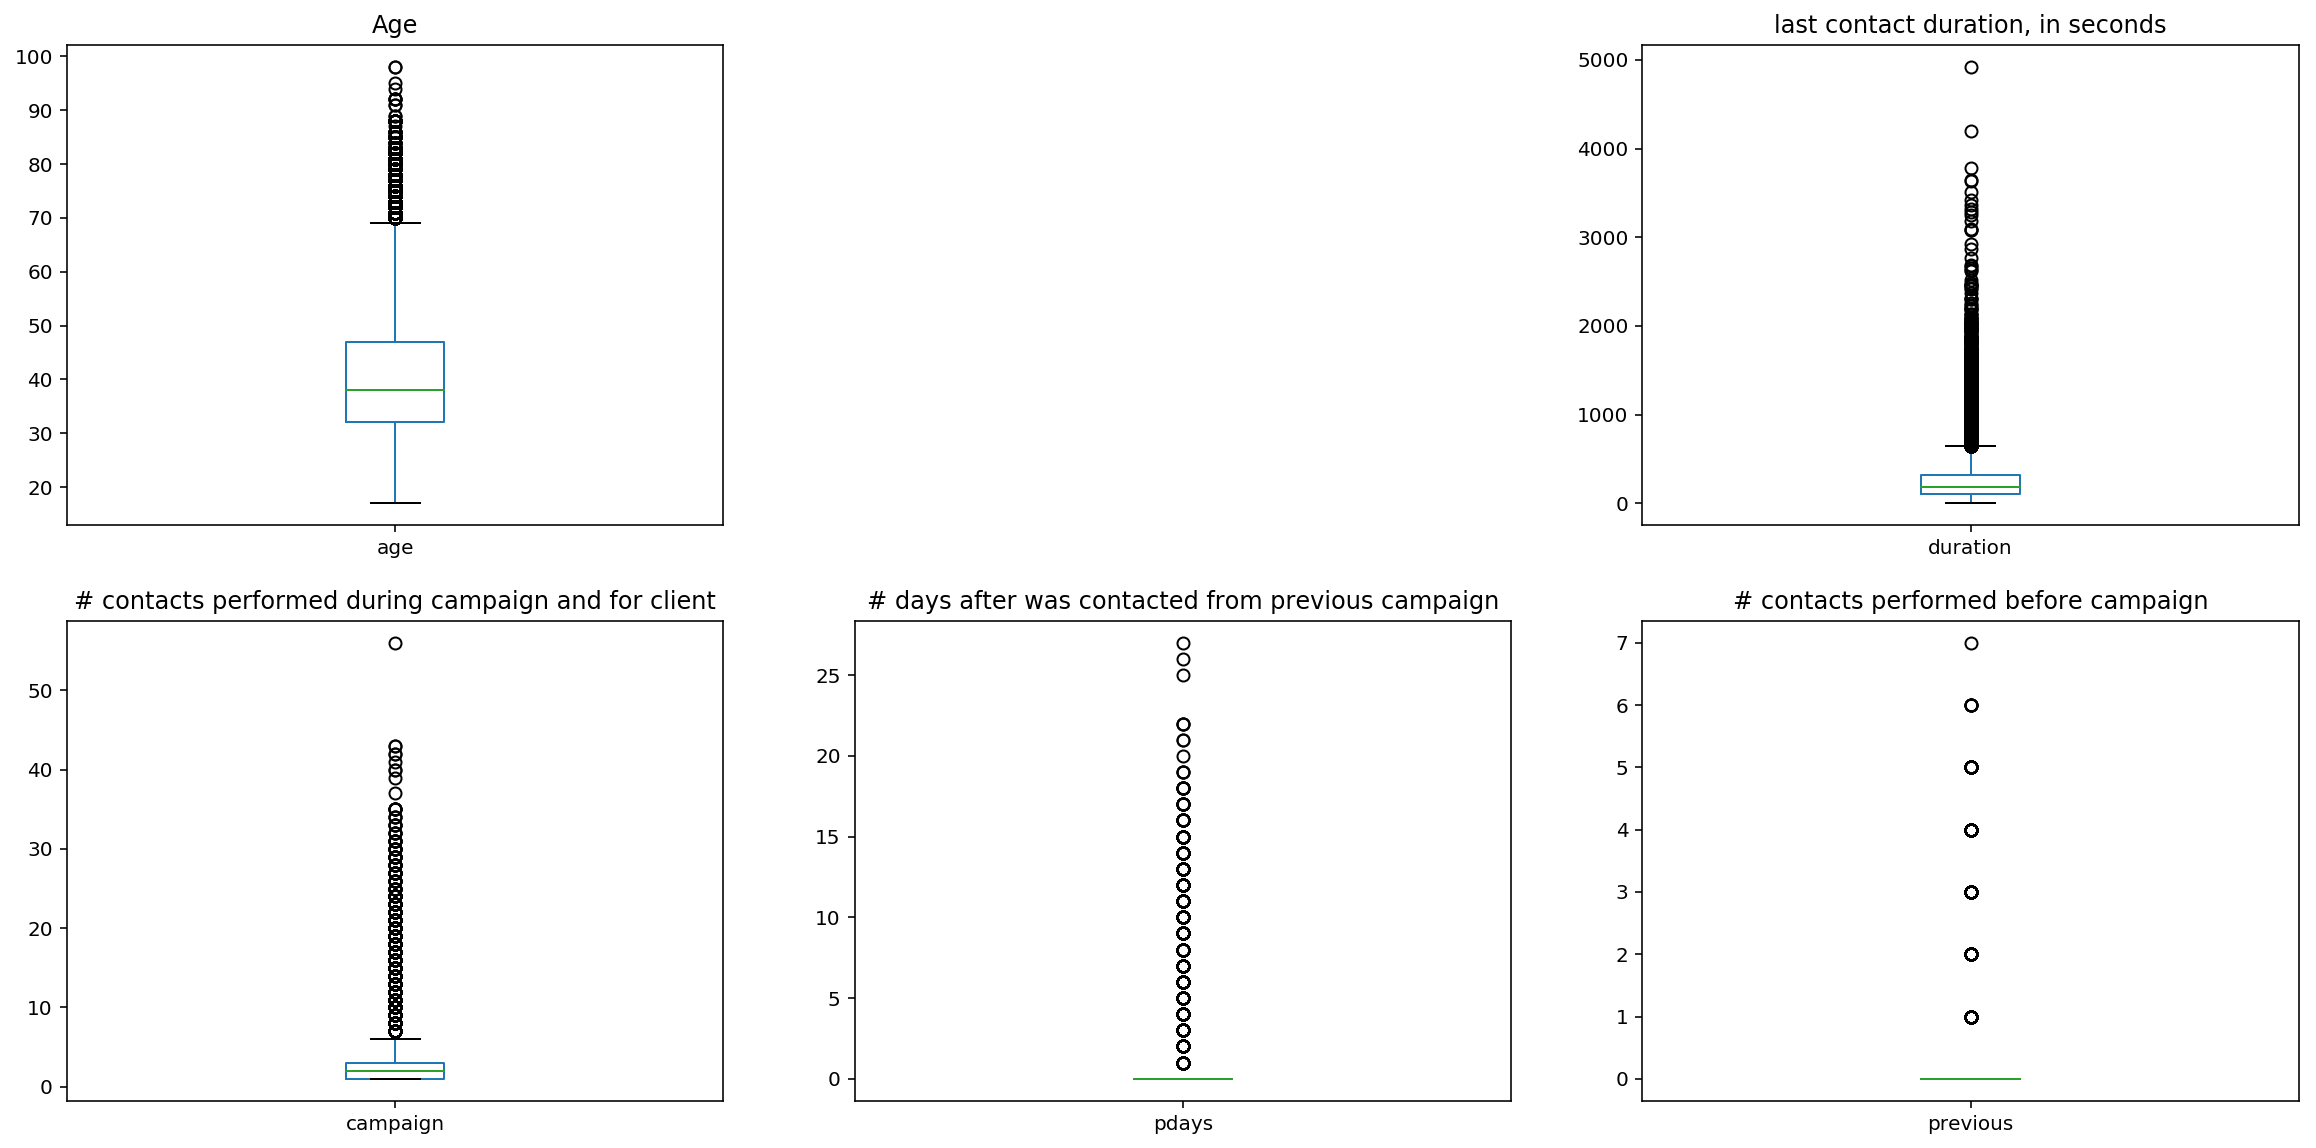

In [10]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (20,15))

plt.subplot(331)
data_add_train["age"].plot(kind='box')
plt.title('Age')

# plt.subplot(332)
# data_add_train["balance"].plot(kind='box')
# plt.title('Balance')

plt.subplot(333)
data_add_train["duration"].plot(kind='box')
plt.title('last contact duration, in seconds')

plt.subplot(334)
data_add_train["campaign"].plot(kind='box')
plt.title('# contacts performed during campaign and for client')


plt.subplot(335)
data_add_train["pdays"].plot(kind='box')
plt.title('# days after was contacted from previous campaign')

plt.subplot(336)
data_add_train["previous"].plot(kind='box')
plt.title('# contacts performed before campaign');

* This dataset does have outliers, but let us build a model that are resistant to outliers

### <font color = red > Feature Engineering

In [11]:
# Target Encoding
# Encode the categorical data target to 0's and 1 on Train and Test data
from sklearn.preprocessing import LabelEncoder
Label_encode = LabelEncoder()
data_add_train["Target"] = Label_encode.fit_transform(data_add_train["Target"])
data_add_test["Target"] = Label_encode.fit_transform(data_add_test["Target"])

In [12]:
# Categorical Data - One Hot Encoding on Train and Test data
data_add_train_categorical = data_add_train[['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 
                                              'month', 'day_of_week','poutcome']]

data_add_test_categorical = data_add_test[['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 
                                              'month', 'day_of_week','poutcome']]

one_hot_train = pd.get_dummies(data_add_train_categorical)

one_hot_test = pd.get_dummies(data_add_test_categorical)

In [13]:
 # Numeric data of Train and Test data

data_add_train_numeric = data_add_train[['age','duration','campaign','pdays','previous', 'emp.var.rate',
                                          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'Target']]

data_add_test_numeric = data_add_test[['age','duration','campaign','pdays','previous', 'emp.var.rate',
                                          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'Target']]


In [14]:
## Without scaling data 

## Concat both the numeric and categorical of Train data
Train_val_data = pd.concat([data_add_train_numeric,one_hot_train],axis =1)

## Concat both the numeric and categorical Train data
Test_data = pd.concat([data_add_test_numeric,one_hot_test],axis =1)


### <font color = red > Train and Validation 

In [15]:
from sklearn.model_selection import train_test_split

Train_val_data_ = Train_val_data.drop(['Target'],axis = 1)
y = Train_val_data['Target']
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(Train_val_data_, y, test_size=0.25,stratify=y, random_state=27)


### <font color = red > Sampling the data through SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)

x_res, y_res = sm.fit_sample(X_train, y_train)

X_train_smote_ = pd.DataFrame(x_res, columns=X_train.columns)
y_train_smote = pd.DataFrame({'Target':y_res})

Sample_smote_12 = pd.concat([X_train_smote_, y_train_smote],axis = 1)

Sample_smote_12.head()

Using TensorFlow backend.


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Target
0,35,437,2,0,0,1.4,94.465,-41.8,4.961,5228.1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,45,222,9,0,0,1.1,93.994,-36.4,4.864,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,41,184,1,0,0,1.4,93.918,-42.7,4.962,5228.1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,54,107,1,2,1,-1.8,93.075,-47.1,1.365,5099.1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,49,790,1,0,0,1.4,93.444,-36.1,4.968,5228.1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


### <font color = red> Decision Tree Classifier

In [159]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT = DT.fit(Sample_smote_12.drop(['Target'],axis = 1),Sample_smote_12.Target) ## Fit the model


from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from imblearn.metrics import specificity_score

THRESHOLD = 0.5
prediction = np.where(DT.predict_proba(X_test)[:,1 ] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, prediction), recall_score(y_test, prediction),
                   precision_score(y_test, prediction), roc_auc_score(y_test, prediction)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])



,0
accuracy,0.883267
recall,0.539655
precision,0.483771
roc_auc_score,0.733273


### <font color = red > Random Forest

#### <font color = blue > Grid Search Optimization

In [17]:
## Hyper Parameter Tuning through gridsearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import recall_score


model_params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

# create random forest classifier model
rf_model = RandomForestClassifier(random_state=1)

# set up grid search meta-estimator
clf = GridSearchCV(rf_model, model_params,scoring = 'recall' ,n_jobs = -1, cv=5)

# train the grid search meta-estimator to find the best model
model = clf.fit(Sample_smote_12.drop(['Target'],axis = 1),Sample_smote_12.Target)

# print winning set of hyperparameters in the model
from pprint import pprint
print(model.best_estimator_.get_params())

{'oob_score': False, 'class_weight': None, 'n_jobs': None, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'warm_start': False, 'criterion': 'gini', 'max_leaf_nodes': None, 'bootstrap': True, 'random_state': 1, 'max_features': 1.0, 'min_samples_split': 2, 'verbose': 0, 'min_samples_leaf': 1, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'max_depth': None, 'n_estimators': 250}


In [18]:
RFC = RandomForestClassifier(n_estimators = 250, max_depth = None, min_samples_split = 4)
#rfe = rfe.fit(features_smote,target_smote)

RFC = RFC.fit(Sample_smote_12.drop(['Target'],axis = 1),Sample_smote_12.Target)

######


from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from imblearn.metrics import specificity_score

THRESHOLD = 0.5
prediction = np.where(RFC.predict_proba(X_test)[:,1 ] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, prediction), recall_score(y_test, prediction),
                   precision_score(y_test, prediction), roc_auc_score(y_test, prediction)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])



,0
accuracy,0.910556
recall,0.512931
precision,0.625657
roc_auc_score,0.736984


#### <font color = blue> Feature Importance 

No handles with labels found to put in legend.


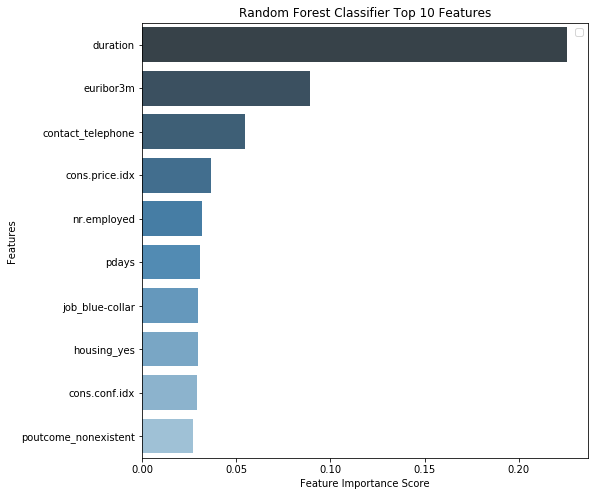

In [18]:
import pandas as pd

data_set = Sample_smote_.drop(['Target'],axis = 1)

feature_importances = pd.DataFrame(RFC.feature_importances_,
                                   index = data_set.columns,
                                columns=['importance']).sort_values('importance',        
                                 ascending=False) 

feature_importances = feature_importances.head(10)

plt.figure(figsize=(8, 8))

#pal = sns.color_palette("Greens_d", len(X))


sns.barplot(x=feature_importances.importance, y=feature_importances.index,palette="Blues_d")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

plt.title("Random Forest Classifier Top 10 Features")
plt.legend()

plt.show()

### <font color = red >Gradient Boosting

#### <font color = blue > Hyper Parameter tuning through grid search

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


params_1 = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
'min_child_weight': [1, 3, 5, 7, 10],
'gamma': [0, 0.1, 0.3, 0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
'max_depth': [2, 3, 4, 5, 6, 7]
}

# create random forest classifier model
Gradient_model = GradientBoostingClassifier(random_state=1)

# set up grid search meta-estimator
clf = GridSearchCV(Gradient_model, model_params,scoring = 'recall' ,n_jobs = -1, cv=5)

# train the grid search meta-estimator to find the best model
model = clf.fit(Sample_smote_12.drop(['Target'],axis = 1),Sample_smote_12.Target)

# print winning set of hyperparameters in the model
from pprint import pprint
print(model.best_estimator_.get_params())


{'init': None, 'min_weight_fraction_leaf': 0.0, 'n_iter_no_change': None, 'warm_start': False, 'ccp_alpha': 0.0, 'max_leaf_nodes': None, 'n_estimators': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_depth': 3, 'learning_rate': 0.1, 'loss': 'deviance', 'max_features': 1.0, 'min_samples_split': 2, 'verbose': 0, 'presort': 'deprecated', 'criterion': 'friedman_mse', 'min_impurity_split': None, 'random_state': 1, 'tol': 0.0001}


In [20]:
# Load the model
GB = GradientBoostingClassifier( learning_rate = 0.1, validation_fraction = 0.1, random_state = 1, min_weight_fraction_leaf = 0.0, n_estimators = 10, 
                                  max_leaf_nodes = None, loss = 'deviance', 
                                 criterion= 'friedman_mse', max_features = 1.0, min_samples_split = 2, max_depth = 3, verbose = 0, 
                                 min_impurity_split= None, min_impurity_decrease = 0.0, min_samples_leaf = 1)

# Fit the model
GB = GB.fit(Sample_smote_12.drop(['Target'],axis = 1),Sample_smote_12.Target)


# Test the model
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from imblearn.metrics import specificity_score

THRESHOLD = 0.5
prediction = np.where(GB.predict_proba(X_test)[:,1 ] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, prediction), recall_score(y_test, prediction),
                   precision_score(y_test, prediction), roc_auc_score(y_test, prediction)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])



,0
accuracy,0.833738
recall,0.925000
precision,0.397702
roc_auc_score,0.873576


* The Recall Score is Excellent!! 
* This say's the model is very effective in predicting High number of Customers who are potential to subsbscribe term-deposit.

#### <font color = red > Feature Importance of Gradient Boosting Model

No handles with labels found to put in legend.


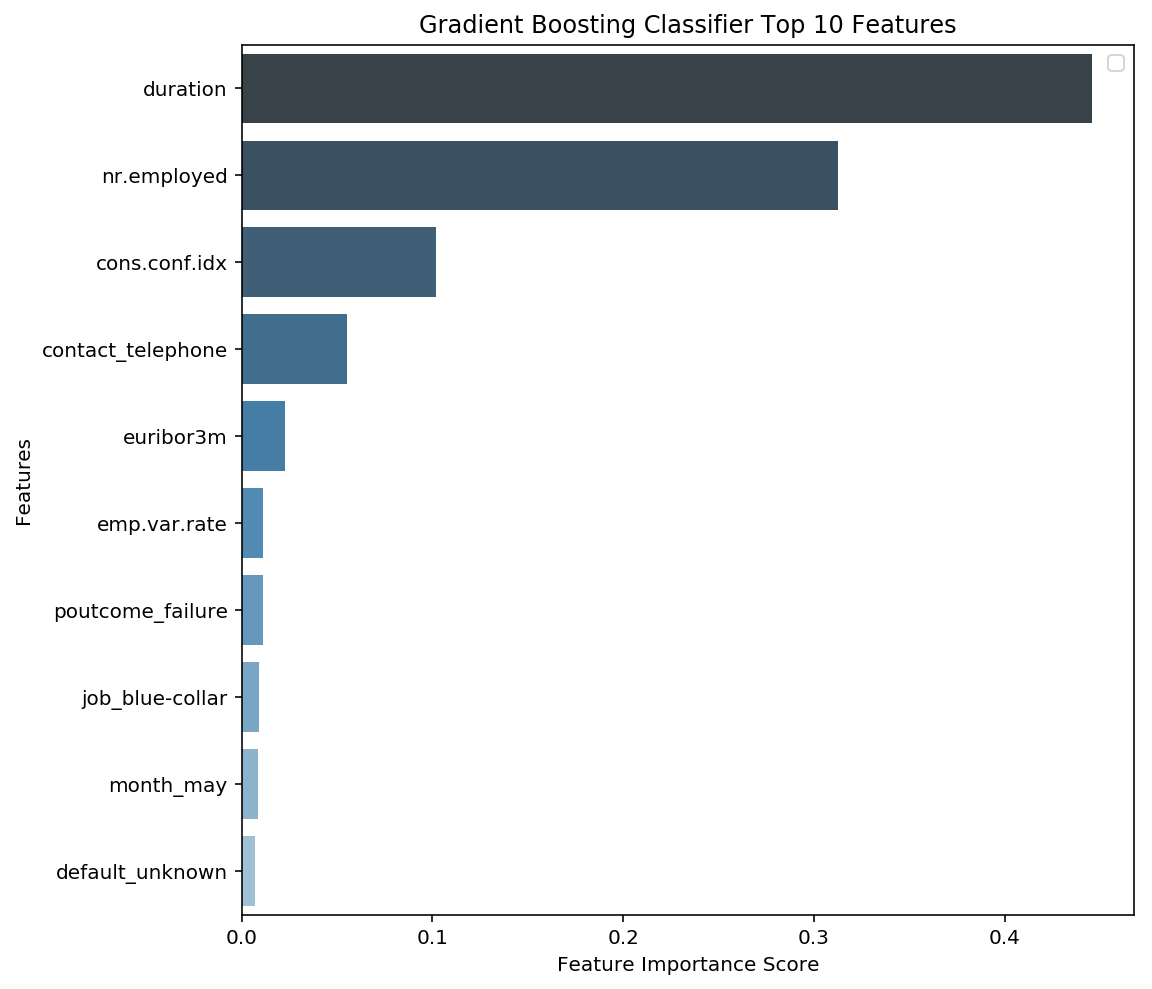

In [21]:
import pandas as pd

data_set = Sample_smote_.drop(['Target'],axis = 1)

feature_importances = pd.DataFrame(GB.feature_importances_,
                                   index = data_set.columns,
                                columns=['importance']).sort_values('importance',        
                                 ascending=False) 

feature_importances = feature_importances.head(10)

plt.figure(figsize=(8, 8))

sns.barplot(x=feature_importances.importance, y=feature_importances.index,palette="Blues_d")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

plt.title("Gradient Boosting Classifier Top 10 Features")
plt.legend()

plt.show()

In [152]:
## Let's Test on our test data

Test_data_X = Test_data.drop(['Target'],axis = 1)
Test_data_Y = Test_data.Target
THRESHOLD = 0.5
prediction = np.where(GB.predict_proba(Test_data_X)[:,1 ] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(Test_data_Y, prediction), recall_score(Test_data_Y, prediction),
                   precision_score(Test_data_Y, prediction), roc_auc_score(Test_data_Y, prediction)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.834669
recall,0.924612
precision,0.391917
roc_auc_score,0.874111


### <font color = red> Model Evaluation

#### <font color = blue > Confusion Matrix

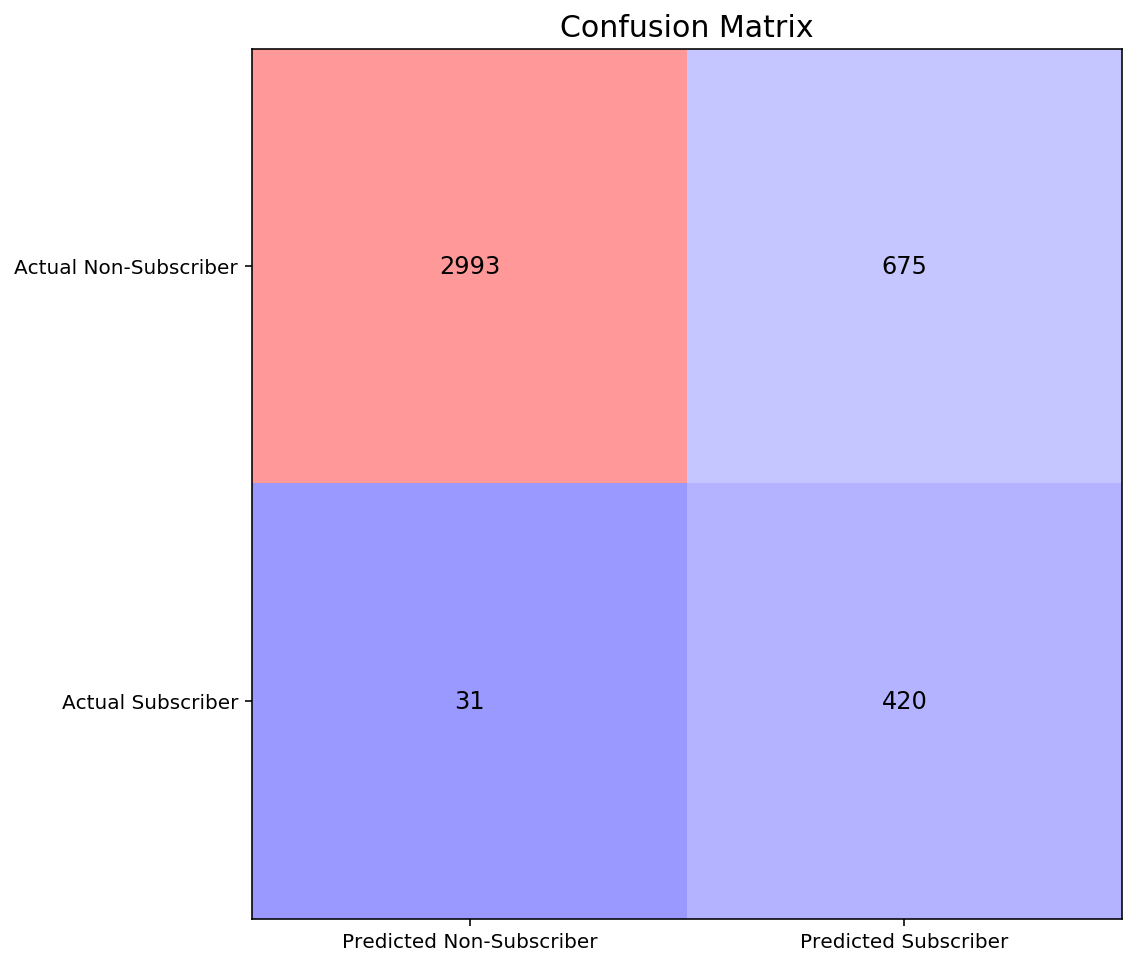

In [96]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Test_data_Y, GB.predict(Test_data_X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm,cmap='bwr',alpha = 0.4)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Non-Subscriber', 'Predicted Subscriber'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Non-Subscriber', 'Actual Subscriber'))
ax.set_ylim(1.5, -0.5)
plt.title('Confusion Matrix',fontsize = 15)
for i in range(2):
     for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center',fontsize=12, color='black')
plt.show()

#### <font color = blue > Classification Report

In [97]:
from sklearn.metrics import classification_report
target_names = ['Non-Subscribers', 'Subscribers']
print(classification_report(Test_data_Y, prediction, target_names=target_names))

                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.82      0.89      3668
    Subscribers       0.38      0.93      0.54       451

       accuracy                           0.83      4119
      macro avg       0.69      0.87      0.72      4119
   weighted avg       0.92      0.83      0.86      4119



#### <font color = blue > ROC - Curve

<Figure size 432x288 with 0 Axes>

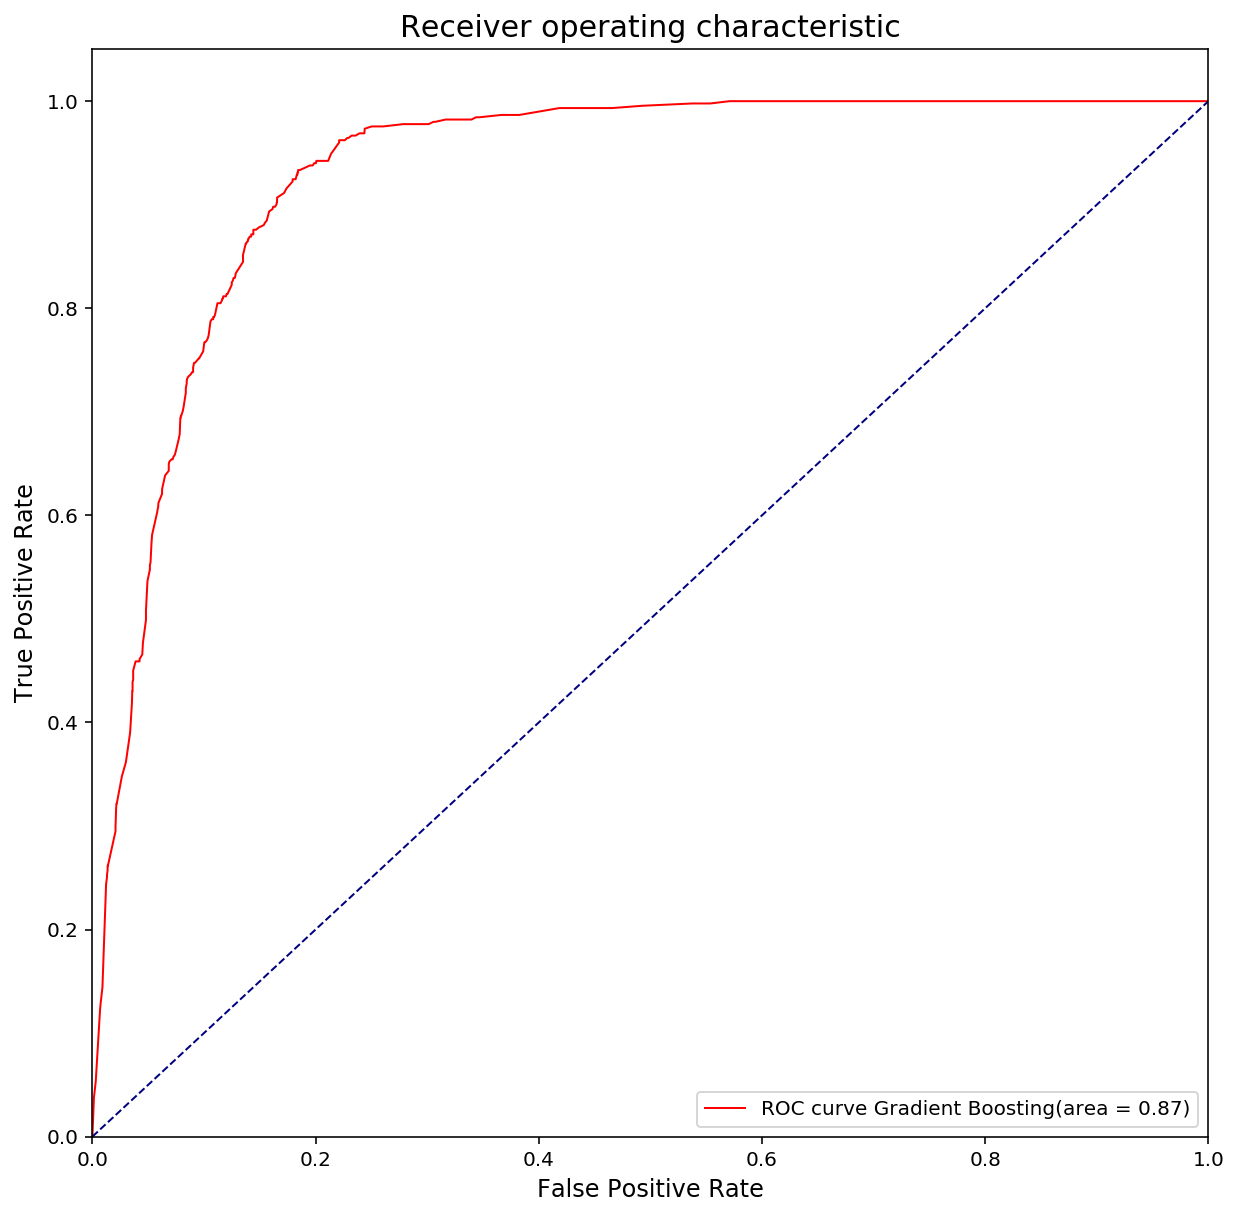

In [114]:
from sklearn.metrics import roc_curve, auc

#### Predictions

predictions_GB_y_pred_1 = GB.predict_proba(Test_data_X)

predictions_GB_y_pred = GB.predict(Test_data_X)

fprXG, tprXG, thresholdsXG = roc_curve(Test_data_Y, predictions_GB_y_pred) 

predictions_GB_y_pred = GB.predict(Test_data_X)

fprXG_1,tprXG_1, thresholdsXG_1 = roc_curve(Test_data_Y.values,predictions_GB_y_pred_1[:,1])

roc_aucXG = auc(fprXG, tprXG)

plt.figure()
plt.figure(figsize=(10,10))

plt.plot(fprXG_1, tprXG_1, color='red',ls = '-', lw=1, label='ROC curve Gradient Boosting(area = %0.2f)' % roc_aucXG)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('True Positive Rate',fontsize = 12)
plt.title('Receiver operating characteristic',fontsize=15)

plt.legend(loc="lower right")
plt.show()


### <font Color = red > Additional Models

#### <font color = blue > Logistic Regression

##### <font color = black > Data Preprocessing

In [127]:
# Read data

data_add_train = pd.read_csv("bank-additional-full.csv",header = 0, sep = ";")

data_add_test = pd.read_csv("bank-additional.csv",header = 0, sep = ";")

## Replace 999 value in pdays and replace it with Zero
data_add_train.pdays[data_add_train.pdays == 999] = 0
data_add_test.pdays[data_add_test.pdays == 999] = 0

# Rename Column name
data_add_train.rename(columns={'y': 'Target'}, inplace=True)
data_add_test.rename(columns={'y': 'Target'}, inplace=True)



In [128]:
### Oultier Removal using IQR
Q1 = data_add_train.quantile(0.25)
Q3 = data_add_train.quantile(0.75)
IQR = Q3 - Q1

df = data_add_train[~((data_add_train < (Q1 - 1.5 * IQR)) |(data_add_train > (Q3 + 1.5 * IQR))).any(axis=1)]
print('Before Removing Oultiers, the data has nearly %d rows' %(data_add_train.shape[0]))
print('\n')
print('After  Removing Oultiers, the data has nearly %d rows' %(df.shape[0]))

Before Removing Oultiers, the data has nearly 41188 rows


After  Removing Oultiers, the data has nearly 30360 rows


* Nearly 26.2% of data contains Outliers

##### <font color = black> Remove Correlated Features in the dataset

In [129]:
### In the Exploratory data analysis study we found that socio-economic context features are suffering with multi-collinearity

data_add_train_Log_Reg = data_add_train.drop(['emp.var.rate','cons.price.idx','euribor3m','nr.employed'],axis = 1)

data_add_test_Log_Reg = data_add_test.drop(['emp.var.rate','cons.price.idx','euribor3m','nr.employed'],axis = 1)

In [130]:
# # Target Encoding
# # Encode the categorical data target to 0's and 1 on Train and Test data
from sklearn.preprocessing import LabelEncoder
Label_encode = LabelEncoder()
data_add_train["Target"] = Label_encode.fit_transform(data_add_train["Target"])
data_add_test["Target"] = Label_encode.fit_transform(data_add_test["Target"])

##### <font color = black > Feature Scaling
* Standardization - For Logistic Regression

In [131]:
data_add_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [132]:
# Split the features into Numerical and Categorical

# Numerical data
data_add_train_Log_Reg_Numeric = data_add_train_Log_Reg[['age','duration','campaign','pdays','previous','cons.conf.idx']]

data_add_test_Log_Reg_Numeric = data_add_test_Log_Reg[['age','duration','campaign','pdays','previous','cons.conf.idx']]

# Categorical Data
data_add_train_Log_Reg_Categorical = data_add_train_Log_Reg[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']]

data_add_test_Log_Reg_Categorical = data_add_test_Log_Reg[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']]



In [133]:
## Standardization 

# Train data Scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
data = data_add_train_Log_Reg_Numeric
data_scaled = scaler.fit_transform(data)
data_add_train_numeric_ = pd.DataFrame(data_scaled, columns=['age','duration','campaign','pdays','previous','cons.conf.idx'])


## Append target feature to train data
data_add_train_numeric_ = pd.concat([data_add_train_numeric_,data_add_train[['Target']]], axis = 1)
data_add_train_numeric_.head()

## Test data
scaler = StandardScaler() 
data_test = data_add_test_Log_Reg_Numeric
data_scaled_test = scaler.fit_transform(data_test)
data_add_test_numeric_ = pd.DataFrame(data_scaled_test, columns=['age','duration','campaign','pdays','previous','cons.conf.idx'])

## Append target feature to test data
data_add_test_numeric_ = pd.concat([data_add_test_numeric_,data_add_test[['Target']]], axis = 1)
data_add_test_numeric_.head()


,age,duration,campaign,pdays,previous,cons.conf.idx,Target
0,-0.980752,0.903952,-0.209228,-0.166358,-0.351356,-1.240939,0
1,-0.107991,0.350300,0.569634,-0.166358,-0.351356,0.892269,0
2,-1.465619,-0.116966,-0.598660,-0.166358,-0.351356,-0.283172,0
3,-0.204965,-0.941553,0.180203,-0.166358,-0.351356,-0.283172,0
4,0.667795,-0.780563,-0.598660,-0.166358,-0.351356,-0.326707,0


In [134]:
data_add_test_Log_Reg_Numeric.isnull().sum()

age              0
duration         0
campaign         0
pdays            0
previous         0
cons.conf.idx    0
dtype: int64

In [78]:
data_add_train_numeric_.head()

,age,duration,campaign,pdays,previous,cons.conf.idx,Target
0,1.533034,0.010471,-0.565922,-0.164012,-0.349494,0.886447,0
1,1.628993,-0.421501,-0.565922,-0.164012,-0.349494,0.886447,0
2,-0.290186,-0.124520,-0.565922,-0.164012,-0.349494,0.886447,0
3,-0.002309,-0.413787,-0.565922,-0.164012,-0.349494,0.886447,0
4,1.533034,0.187888,-0.565922,-0.164012,-0.349494,0.886447,0


##### <font color = black> Feature Engineering

In [135]:
# Categorical Data - One Hot Encoding on Train and Test data
data_add_train_categorical = data_add_train[['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 
                                              'month', 'day_of_week','poutcome']]

data_add_test_categorical = data_add_test[['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 
                                              'month', 'day_of_week','poutcome']]

one_hot_train = pd.get_dummies(data_add_train_categorical)

one_hot_test = pd.get_dummies(data_add_test_categorical)

In [108]:
one_hot_test.isnull().sum()

job_admin.                       0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
job_unknown                      0
marital_divorced                 0
marital_married                  0
marital_single                   0
marital_unknown                  0
education_basic.4y               0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
education_illiterate             0
education_professional.course    0
education_university.degree      0
education_unknown                0
default_no                       0
default_unknown                  0
default_yes                      0
housing_no                       0
housing_unknown     

In [136]:
## Concat both the numeric and categorical of Train data
Train_val_data = pd.concat([data_add_train_numeric_,one_hot_train],axis =1)

## Concat both the numeric and categorical Train data
Test_data_Log_Reg = pd.concat([data_add_test_numeric_,one_hot_test],axis =1)
Test_data_Log_Reg.head()

,age,duration,campaign,pdays,previous,cons.conf.idx,Target,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.980752,0.903952,-0.209228,-0.166358,-0.351356,-1.240939,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,-0.107991,0.350300,0.569634,-0.166358,-0.351356,0.892269,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,-1.465619,-0.116966,-0.598660,-0.166358,-0.351356,-0.283172,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3,-0.204965,-0.941553,0.180203,-0.166358,-0.351356,-0.283172,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0.667795,-0.780563,-0.598660,-0.166358,-0.351356,-0.326707,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [137]:
### Train and Validation on Data
Test_data_Log_Reg.isnull().sum()
data_add_test_numeric_.tail()

,age,duration,campaign,pdays,previous,cons.conf.idx,Target
4114,-0.980752,-0.800196,-0.598660,-0.166358,-0.351356,-0.479079,0
4115,-0.107991,-0.148379,-0.598660,-0.166358,-0.351356,-0.479079,0
4116,-1.271672,-0.757003,-0.209228,-0.166358,1.494607,-1.240939,0
4117,1.734503,1.064943,-0.598660,-0.166358,-0.351356,0.957571,0
4118,-0.592858,-0.321150,-0.598660,-0.166358,-0.351356,-0.326707,0


In [138]:

from sklearn.model_selection import train_test_split

Train_val_data_ = Train_val_data.drop(['Target'],axis = 1)
y = Train_val_data['Target']

# setting up testing and training sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(Train_val_data_, y, test_size=0.25,stratify=y, random_state=27)


##### Sampling through SMOTE

In [139]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)

x_res, y_res = sm.fit_sample(X_train_1, y_train_1)

X_train_smote_ = pd.DataFrame(x_res, columns=X_train_1.columns)
y_train_smote = pd.DataFrame({'Target':y_res})

Sample_smote_123 = pd.concat([X_train_smote_, y_train_smote],axis = 1)

Sample_smote_123.head()

,age,duration,campaign,pdays,previous,cons.conf.idx,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Target
0,-0.482104,0.689284,-0.204909,-0.164012,-0.349494,-0.280328,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0.477486,-0.139947,2.322186,-0.164012,-0.349494,0.886447,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,0.093650,-0.286509,-0.565922,-0.164012,-0.349494,-0.474791,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1.341116,-0.583490,-0.565922,1.318724,1.671136,-1.425496,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0.861322,2.050767,-0.565922,-0.164012,-0.349494,0.951267,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


##### Logistic Regression Model

In [140]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg = LogReg.fit(Sample_smote_123.drop(['Target'],axis = 1),Sample_smote_123.Target)

pred_rf = LogReg.predict(X_test_1) ## Predictions
print('Test Accuracy',LogReg.score(X_test_1,y_test_1))

THRESHOLD = 0.5
prediction_log_Reg = np.where(LogReg.predict_proba(X_test_1)[:,1 ] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, prediction_log_Reg), recall_score(y_test, prediction_log_Reg),
                   precision_score(y_test, prediction_log_Reg), roc_auc_score(y_test, prediction_log_Reg)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])



Test Accuracy 0.9067689618335437


,0
accuracy,0.906769
recall,0.443966
precision,0.620482
roc_auc_score,0.704745
